In [38]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from PIL import Image
import time
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Check cuda version in cmd
# nvcc --version
# Check GPU in cmd
# nvidia-smi

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Set the random seed for CPU operations
seed = 16
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Check if CUDA is available and set the random seed for GPU operations
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [4]:
# Check PyTorch version
print("PyTorch version:", torch.__version__)
# Show Cuda GPU device
print(torch.cuda.get_device_name(0))
print(torch.cuda.get_arch_list())
print(torch.backends.cudnn.version())

PyTorch version: 2.0.1
NVIDIA GeForce GTX 1050 Ti
['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90', 'compute_37']
8700


In [5]:
# GOOGLE COLAB

# Import dataset from gdrive

# from google.colab import drive
# drive.mount('/content/drive')
# !pwd

# Open one image from the dataset (Google Colab)

# path = "drive/My Drive/Master/dataset/"
# with Image.open(path + 'frost/3600.jpg') as img:
#     print("\t")
#     display(img)

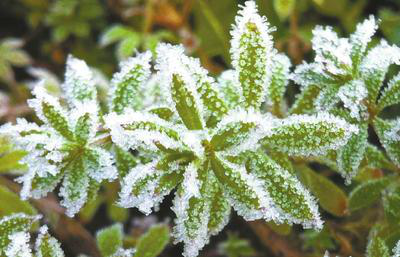

In [6]:
# Open one image from the dataset (Locally)
path = 'dataset'
with Image.open(path + '/frost/3600.jpg') as img:
    display(img)

In [7]:
# Create ImageFolder Dataset
dataset = datasets.ImageFolder(path, transform=None)
dataset

Dataset ImageFolder
    Number of datapoints: 6862
    Root location: dataset

In [8]:
# Display number of classes in the dataset
classes = dataset.classes
print(classes)
print("\t")
print("Number of classes:", len(classes))

['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
	
Number of classes: 11


## Convert dataset into CSV file

In [9]:
# List to store image paths and corresponding labels
data = []

# Loop through each label directory
for label_name in os.listdir(path):
    label_dir = os.path.join(path, label_name)
    if os.path.isdir(label_dir):
        # Loop through each image file in the label directory
        for filename in os.listdir(label_dir):
            if filename.endswith('.jpg'):
                image_path = os.path.join(label_dir, filename)
                label = label_name
                data.append((image_path, label))

# Convert the data list into a Pandas DataFrame
df = pd.DataFrame(data, columns=['image_path', 'label'])

# Save the DataFrame to a CSV file
csv_file = 'dataset.csv'  # Change the filename if desired
df.to_csv(csv_file, index=False)

In [10]:
# Load csv file and show first 5 rows
df = pd.read_csv('dataset.csv')
df.head() 

,image_path,label
0,dataset\dew\2208.jpg,dew
1,dataset\dew\2209.jpg,dew
2,dataset\dew\2210.jpg,dew
3,dataset\dew\2211.jpg,dew
4,dataset\dew\2212.jpg,dew


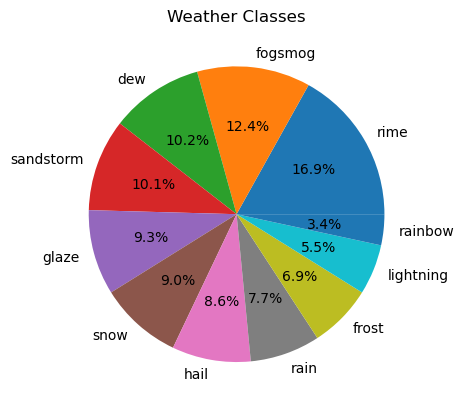

In [11]:
# Plot a pie chart to visualize % of each class in the dataset
label_counts = df["label"].value_counts()
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%')
plt.title('Weather Classes')
plt.show()

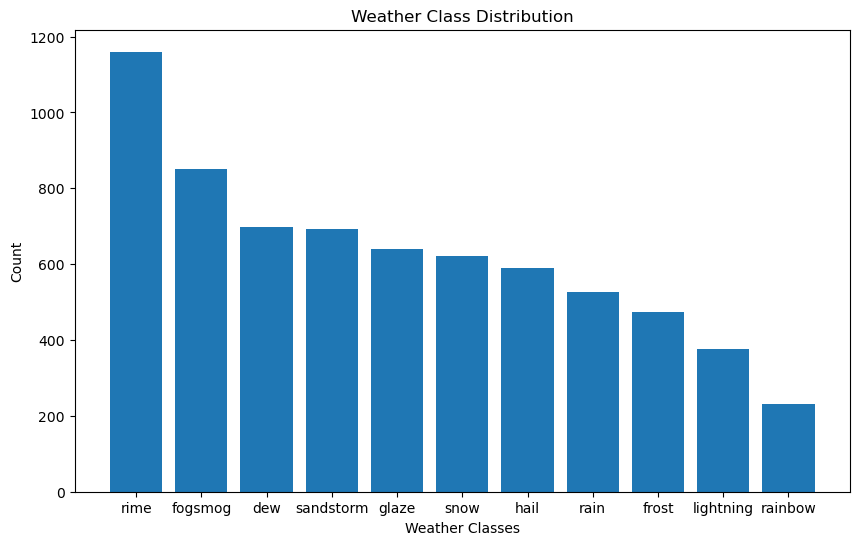

In [12]:
# Plot a bar chart to visualize the count of each class in the dataset
label_counts = df["label"].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(label_counts.index, label_counts)
plt.xlabel('Weather Classes')
plt.ylabel('Count')
plt.title('Weather Class Distribution')
plt.show()

## Split dataset into train, validation and test sets

In [13]:
# Split dataset into train and test
train_size_old = int(0.85 * len(dataset))
test_size = len(dataset) - train_size_old
train_data_old, test_data = torch.utils.data.random_split(dataset, [train_size_old, test_size])

# Split dataset to train and validation
train_size = int(0.85 * len(train_data_old))
validation_size = len(train_data_old) - train_size
train_data, validation_data = torch.utils.data.random_split(train_data_old, [train_size, validation_size])

## Define transforms for each set

In [14]:
# Define the normalization values for mean and standard deviation
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Apply transformation mechanism for each set
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.5,contrast=0.3,saturation=0.5,hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
train_data.dataset.transform = train_transform

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
validation_data.dataset.transform = val_transform

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
test_data.dataset.transform = test_transform

## Create initial data loaders for each set of data

In [15]:
# Batch size
batch = 32

# Define Data Loaders
train_loader = DataLoader(train_data, batch_size=batch, pin_memory=True, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch, pin_memory=True, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch, pin_memory=True, shuffle=False)

# Define variables for sizes of each set
train_data_len = len(train_data)
val_data_len = len(validation_data)
test_data_len = len(test_data)

print("Training images available:", train_data_len)
print("\t")
print("Validation images available:", val_data_len)
print("\t")
print("Testing images available:", test_data_len)

Training images available: 4957
	
Validation images available: 875
	
Testing images available: 1030


In [16]:
# Display one tensor from train data
train_data[0]

(tensor([[[-1.6384, -1.6384, -1.6384,  ..., -1.4500, -1.4500, -1.4500],
          [-1.6213, -1.6213, -1.6384,  ..., -1.4672, -1.4672, -1.4500],
          [-1.6213, -1.6213, -1.6384,  ..., -1.4672, -1.5014, -1.4500],
          ...,
          [-1.5014, -1.5870, -1.2959,  ..., -0.9534, -1.0219, -1.0219],
          [-1.5528, -1.6384, -1.7069,  ..., -1.0219, -1.0219, -1.0390],
          [-1.5870, -1.6898, -1.7754,  ..., -1.0390, -1.0390, -1.0733]],
 
         [[-1.2829, -1.3004, -1.3004,  ..., -0.9853, -1.0203, -0.9853],
          [-1.2654, -1.2829, -1.3004,  ..., -1.0028, -1.0203, -0.9853],
          [-1.2654, -1.2829, -1.3004,  ..., -1.0203, -1.0203, -0.9853],
          ...,
          [-1.1429, -1.2479, -0.9853,  ..., -0.4426, -0.4426, -0.4601],
          [-1.2129, -1.3179, -1.4230,  ..., -0.4776, -0.4251, -0.4601],
          [-1.2829, -1.3880, -1.4580,  ..., -0.4776, -0.4251, -0.4601]],
 
         [[-1.6302, -1.6476, -1.6476,  ..., -1.7347, -1.7173, -1.7173],
          [-1.6127, -1.6302,

Class Indexes: [ 2  8  4  9  1  1  5  9  8  4 10  0  1  2  4  5]
	
Sample image size: torch.Size([3, 224, 224])
	


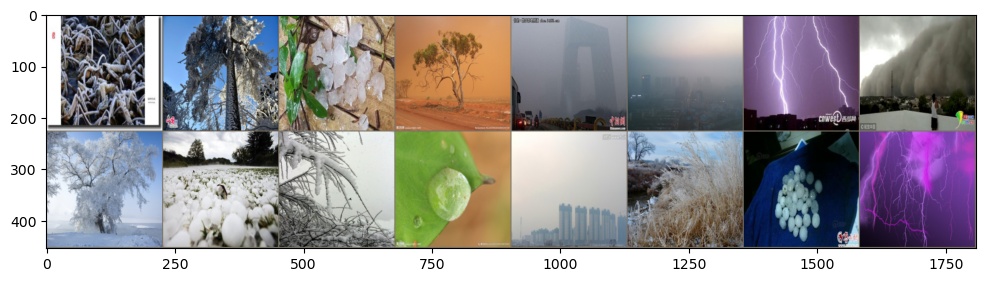

In [17]:
# Grab the first batch of images
for images, labels in train_loader: 
    break
    
# Extract the first 16 images
images_subset = images[:16]
labels_subset = labels[:16]

# Print the labels
print('Class Indexes:', labels_subset.numpy())
print("\t")

# Make a grid with 8 images in each row
im = make_grid(images_subset, nrow=8)

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

# Check one image shape
print("Sample image size:", images_subset[0].shape)
print("\t")

# Define functions

## Count number of trainable parameters

In [18]:
def count_parameters(model):
    
    print("Total sum of trainable weights in the model:")
    print("\t")
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

## Move optimizer to GPU

In [19]:
def move_model_and_optimizer_to_gpu(model, optimizer):
    
    # Move model to Cuda GPU
    model.to(device)
    print(next(model.parameters()).is_cuda)
    
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)

## Hyperparameter tuning

In [1]:
def hyperparameter_tuning(model, learning_rates, batch_sizes, model_name):

    start_time = time.time()
    model_name = model_name

    best_lr = None
    best_batch_size = None
    best_accuracy = 0.0
    epochs = 50

    
    for lr in learning_rates:
        for batch in batch_sizes:

            train_loader = DataLoader(train_data, batch_size=batch, pin_memory=True, shuffle=True)
            validation_loader = DataLoader(validation_data, batch_size=batch, pin_memory=True, shuffle=False)
            
            if model_name == "ShuffleNet":
                model = models.shufflenet_v2_x2_0(pretrained=True)
                for param in model.parameters():
                    param.requires_grad = False
                model.fc = nn.Linear(2048, 11)
                optimizer = torch.optim.AdamW(model.fc.parameters(), lr=lr)
            else:
                print("None of the models match")
                
            criterion = nn.CrossEntropyLoss()       

            # Move optimizer state to the GPU
            move_model_and_optimizer_to_gpu(model, optimizer)

            print("\t")
            print(f"training {model_name} with learning rate:", lr, "and batch size:", batch)
            print("_________________________________________________________________________")
            print("\t")

            # Define patience, counter, best validation accuracy and
            # a boolean value that determines if early stop mechanism is to be activated
            patience = 5
            counter = 0
            best_val_acc = 0
            is_early_stop = False

            # For each epoch run the training and validation bathes
            for epoch in range(epochs):
                train_corr = 0
                validation_corr = 0

                # Run the training batches
                for images, labels in train_loader:
                    
                    images = images.to(device)
                    labels = labels.to(device)

                    # Apply the model for training
                    outputs = model(images)
                    # Number of losses
                    loss = criterion(outputs, labels)

                    # Number of correct predictions
                    predicted = torch.max(outputs.data, 1)[1]
                    train_corr += (predicted == labels).sum()

                    # Update parameters during training
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                # Calculate accuracy after each epoch
                accuracy_train = round(train_corr.item() * 100 / train_data_len, 3)

                # Print each epoch results
                print("Epoch:", epoch + 1, "Train loss:", round(loss.item(), 3), 
                      "Train accuracy:", accuracy_train, "%")




                # Run the validation batches
                model.eval()

                with torch.no_grad():
                    for images, labels in validation_loader:
                        
                        images = images.to(device)
                        labels = labels.to(device)

                        # Apply the model for validation
                        outputs = model(images)
                        # Number of losses
                        loss = criterion(outputs, labels)

                        # Number of correct predictions
                        predicted = torch.max(outputs.data, 1)[1] 
                        validation_corr += (predicted == labels).sum()

                    # Calculate accuracy after each epoch
                    accuracy_val = round(validation_corr.item() * 100 / val_data_len, 3)    



                    # Early stopping
                    if accuracy_val > best_val_acc:
                        best_val_acc = accuracy_val
                        counter = 0
                    else:
                        counter += 1

                    # Check for early stopping after the validation loop    
                    if counter >= patience:
                        is_early_stop = True
                        print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3), 
                              "Validation accuracy:", accuracy_val, "%")            
                        print("Early stopping triggered. Training stopped.")
                        break


                if is_early_stop:
                    break
                else:
                    # Print each epoch results
                    print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3), 
                          "Validation accuracy:", accuracy_val, "%")
                    print("best_val_acc:", round(best_val_acc, 3), "counter:", counter)
                    print("\t")


            # Check if the current hyperparameters achieved better accuracy
            if best_val_acc > best_accuracy:
                best_accuracy = best_val_acc
                best_lr = lr
                best_batch_size = batch
                print("Current best Hyperparameters: Learning Rate:", best_lr, "Batch Size:", best_batch_size, 
                      "Accuracy:", best_accuracy)


    print("\n")
    print("Best Hyperparameters overall: Learning Rate:", best_lr, "Batch Size:", best_batch_size, "Accuracy:", best_accuracy)
    print("\t")
    print("Duration:", round(time.time() - start_time, 1), "seconds")

## Train and validate model

In [21]:
def train_and_val_model(model, criterion, optimizer, train_loader, val_loader, model_name,
                        train_loss_list, train_corr_list, val_loss_list, val_corr_list):
    
    start_time = time.time()
    # Number of epochs
    epochs = 100
    
    model_name = model_name

    # Define patience, counter, best validation accuracy and
    # a boolean value that determines if early stop mechanism is to be activated
    patience = 10
    counter = 0
    best_val_acc = 0
    is_early_stop = False


    # For each epoch run the training and validation bathes
    for epoch in range(epochs):
        train_corr = 0
        validation_corr = 0

        # Run the training batches
        for images, labels in train_loader:

            images = images.to(device)
            labels = labels.to(device)

            # Apply the model for training
            outputs = model(images)
            # Number of losses
            loss = criterion(outputs, labels)

            # number of correct predictions
            predicted = torch.max(outputs.data, 1)[1]
            train_corr += (predicted == labels).sum()

            # Update parameters during training
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Append losses and correct predictions per epoch
        train_loss_list.append(loss)
        train_corr_list.append(train_corr)

        # Calculate accuracy after each epoch
        accuracy_train = round(train_corr.item() * 100 / train_data_len, 3)

        # Print each epoch results
        print("Epoch:", epoch + 1, "Train loss:", round(loss.item(), 3),
              "Train accuracy:", accuracy_train, "%")




        # Run the validation batches
        model.eval()

        with torch.no_grad():
            for images, labels in val_loader:

                images = images.to(device)
                labels = labels.to(device)

                # Apply the model for validation
                outputs = model(images)
                # Number of losses
                loss = criterion(outputs, labels)

                # number of correct predictions
                predicted = torch.max(outputs.data, 1)[1]
                validation_corr += (predicted == labels).sum()

            # Calculate accuracy after each epoch
            accuracy_val = round(validation_corr.item() * 100 / val_data_len, 3)



            # Early stopping
            if accuracy_val > best_val_acc:
                best_val_acc = accuracy_val
                counter = 0

                # Save model with best accuracy
                torch.save(model.state_dict(), f"Best{model_name}.pt")
            else:
                counter += 1

            # Check for early stopping after the validation loop
            if counter >= patience:
                is_early_stop = True
                print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3),
                      "Validation accuracy:", accuracy_val, "%")
                print("Early stopping triggered. Training stopped.")
                break


        # Append losses and correct predictions per epoch
        val_loss_list.append(loss)
        val_corr_list.append(validation_corr)

        if is_early_stop:
            break
        else:
            # Print each epoch results
            print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3),
                  "Validation accuracy:", accuracy_val, "%")
            print("best_val_acc:", round(best_val_acc, 3), "counter:", counter)
            print("\t")


    print("\n")
    print("Duration:", round(time.time() - start_time, 1), "seconds")

## Test model

In [22]:
accuracy_global = 0.0

def test_model(model_best, criterion, test_loader, test_corr_list):

    global accuracy_global
    test_corr = 0

    # Run the test batches
    model_best.eval()

    with torch.no_grad():
        for images, labels in test_loader:

            images = images.to(device)
            labels = labels.to(device)

            # Apply the model for validation
            outputs = model_best(images)
            # Number of losses
            loss = criterion(outputs, labels)

            # number of correct predictions
            predicted = torch.max(outputs.data, 1)[1]
            test_corr += (predicted == labels).sum()

        # Calculate accuracy
        accuracy = round(test_corr.item() * 100 / test_data_len, 3)

    test_corr_list.append(test_corr)
    accuracy_global = accuracy

## Confusion Matrix

In [23]:
def show_confusion_matrix(model_best):
    
    # Create a loader for the entire test set
    test_load_all = DataLoader(test_data, batch_size=test_data_len, shuffle=False)
    model_best.cpu()

    with torch.no_grad():
        
        correct = 0
        predicted_labels = []
        true_labels = []
        
        for images, labels in test_load_all:

            images = images.cpu()
            labels = labels.cpu()

            outputs = model_best(images)
            predicted = torch.max(outputs, 1)[1]
            correct += (predicted == labels).sum()
            
            predicted_labels.extend(predicted.tolist())
            true_labels.extend(labels.tolist())

    arr = confusion_matrix(true_labels, predicted_labels)
    df_cm = pd.DataFrame(arr, classes, classes)
    
    cm_metrics(true_labels, predicted_labels)

    plt.figure(figsize = (9,6))
    sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show();

## Calculate Confusion Matrix metrics

In [24]:
def cm_metrics(true, predicted):

    TP = {}
    FP = {}
    TN = {}
    FN = {}

    for class_label in range(len(classes)):
        TP[class_label] = 0
        FP[class_label] = 0
        TN[class_label] = 0
        FN[class_label] = 0

    for i in range(len(predicted)):
        if true[i] == predicted[i]:
            TP[true[i]] += 1
            for class_label in range(len(classes)):
                if class_label != true[i]:
                    TN[class_label] += 1
        else:
            FP[predicted[i]] += 1
            FN[true[i]] += 1
            for class_label in range(len(classes)):
                if class_label != true[i] and class_label != predicted[i]:
                    TN[class_label] += 1

    precision = {}
    recall = {}
    f1_score = {}

    for class_label in range(len(classes)):
        precision[class_label] = TP[class_label] / (TP[class_label] + FP[class_label])
        recall[class_label] = TP[class_label] / (TP[class_label] + FN[class_label])
        f1_score[class_label] = 2 * (precision[class_label] * recall[class_label]) / (precision[class_label]
                                                                                      + recall[class_label])

    accuracy = accuracy_score(true, predicted)

    macro_precision, macro_recall, macro_f1_score, support = precision_recall_fscore_support(
        true, predicted, average='macro')
    micro_precision, micro_recall, micro_f1_score, support = precision_recall_fscore_support(
        true, predicted, average='micro')
    weighted_precision, weighted_recall, weighted_f1_score, support = precision_recall_fscore_support(
        true, predicted, average='weighted')

    
    print("**********************")
    print("Individual Class Metrics:")
    print("**********************")
    print("\t")
    
    for class_label in range(len(classes)):
        print("Class:", class_label)
        print("---------------------")
        print("True Positive (TP):", round(TP[class_label], 3))
        print("True Negative (TN):", round(TN[class_label], 3))
        print("False Positive (FP):", round(FP[class_label], 3))
        print("False Negative (FN):", round(FN[class_label], 3))
        print("Precision:", round(precision[class_label], 3))
        print("Recall:", round(recall[class_label], 3))
        print("F1 Score:", round(f1_score[class_label], 3))
        print("\t")  
    
    print("\n")
    print("**********************")
    print("Average Metrics:")
    print("**********************")
    print("\t")
    print("Total Accuracy:", round(accuracy, 3))
    print("---------------------")
    print("Macro-Averaged Precision:", round(macro_precision, 3))
    print("Macro-Averaged Recall:", round(macro_recall, 3))
    print("Macro-Averaged F1 Score:", round(macro_f1_score, 3))
    print("---------------------")
    print("Micro-Averaged Precision:", round(micro_precision, 3))
    print("Micro-Averaged Recall:", round(micro_recall, 3))
    print("Micro-Averaged F1 Score:", round(micro_f1_score, 3))
    print("---------------------")
    print("Weighted-Averaged Precision:", round(weighted_precision, 3))
    print("Weighted-Averaged Recall:", round(weighted_recall, 3))
    print("Weighted-Averaged F1 Score:", round(weighted_f1_score, 3))
    print("\t")

## Individual class performance

In [25]:
# def class_performance(model, test_loader):
#     # prepare to count predictions for each class
#     correct_pred = {classname: 0 for classname in classes}
#     total_pred = {classname: 0 for classname in classes}

#     # again no gradients needed
#     with torch.no_grad():
#         for images, labels in test_loader:
#             outputs = model(images)
#             predictions = torch.max(outputs, 1)[1]
#             # collect the correct predictions for each class
#             for label, prediction in zip(labels, predictions):
#                 if label == prediction:
#                     correct_pred[classes[label]] += 1
#                 total_pred[classes[label]] += 1


#     # print accuracy for each class
#     for classname, correct_count in correct_pred.items():
#         accuracy = 100 * float(correct_count) / total_pred[classname]
#         print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

## Model prediction on single image

In [26]:
def custom_img_prediction(model_best, model_name):
    model_name = model_name
    
    model_best.cpu()
    model_best.eval()
    with torch.no_grad():
        custom_pred = model_best(custom_img_t.view(1,3,224,224)).argmax()

    print(f"{model_name} model prediction:", custom_pred.item())

# ShuffleNet

In [27]:
ShuffleNet = models.shufflenet_v2_x2_0(pretrained=True)
ShuffleNet

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_runn

In [28]:
# Freeze the pre-trained layers to prevent their weights from being updated
for param in ShuffleNet.parameters():
    param.requires_grad = False

In [29]:
# Cassifier was modified so that we have 11 output features in the last linear layer instead of 1000
ShuffleNet.fc = nn.Linear(2048, 11)

In [30]:
count_parameters(ShuffleNet)

Total sum of trainable weights in the model:
	
   22528
      11
________
   22539


In [31]:
# Define initial loss and optimization functions
criterion_ShuffleNet = nn.CrossEntropyLoss()
optimizer_ShuffleNet = torch.optim.AdamW(ShuffleNet.fc.parameters(), lr=0.001)

In [32]:
# Move model and optimizer to cuda
move_model_and_optimizer_to_gpu(ShuffleNet, optimizer_ShuffleNet)

True


## Hyperparameter tuning

In [173]:
learning_rates = [0.0001, 0.0005, 0.001]
batch_sizes = [32, 64, 128]

hyperparameter_tuning(ShuffleNet, learning_rates, batch_sizes, "ShuffleNet")

True
	
training ShuffleNet with learning rate: 0.0001 and batch size: 32
_________________________________________________________________________
	
Epoch: 1 Train loss: 1.605 Train accuracy: 41.436 %
Epoch: 1 Validation loss: 1.647 Validation accuracy: 65.829 %
best_val_acc: 65.829 counter: 0
	
Epoch: 2 Train loss: 1.251 Train accuracy: 73.391 %
Epoch: 2 Validation loss: 1.296 Validation accuracy: 74.971 %
best_val_acc: 74.971 counter: 0
	
Epoch: 3 Train loss: 1.043 Train accuracy: 80.331 %
Epoch: 3 Validation loss: 1.071 Validation accuracy: 79.429 %
best_val_acc: 79.429 counter: 0
	
Epoch: 4 Train loss: 0.714 Train accuracy: 83.559 %
Epoch: 4 Validation loss: 0.921 Validation accuracy: 83.086 %
best_val_acc: 83.086 counter: 0
	
Epoch: 5 Train loss: 0.515 Train accuracy: 85.294 %
Epoch: 5 Validation loss: 0.83 Validation accuracy: 84.114 %
best_val_acc: 84.114 counter: 0
	
Epoch: 6 Train loss: 0.63 Train accuracy: 86.665 %
Epoch: 6 Validation loss: 0.753 Validation accuracy: 84.686 %

Epoch: 22 Train loss: 0.252 Train accuracy: 91.527 %
Epoch: 22 Validation loss: 0.512 Validation accuracy: 88.457 %
best_val_acc: 88.457 counter: 0
	
Epoch: 23 Train loss: 0.217 Train accuracy: 91.85 %
Epoch: 23 Validation loss: 0.513 Validation accuracy: 88.457 %
best_val_acc: 88.457 counter: 1
	
Epoch: 24 Train loss: 0.367 Train accuracy: 91.87 %
Epoch: 24 Validation loss: 0.508 Validation accuracy: 88.457 %
best_val_acc: 88.457 counter: 2
	
Epoch: 25 Train loss: 0.301 Train accuracy: 92.052 %
Epoch: 25 Validation loss: 0.504 Validation accuracy: 88.229 %
best_val_acc: 88.457 counter: 3
	
Epoch: 26 Train loss: 0.187 Train accuracy: 92.334 %
Epoch: 26 Validation loss: 0.496 Validation accuracy: 88.343 %
Early stopping triggered. Training stopped.
True
	
training ShuffleNet with learning rate: 0.0001 and batch size: 128
_________________________________________________________________________
	
Epoch: 1 Train loss: 2.036 Train accuracy: 30.765 %
Epoch: 1 Validation loss: 2.007 Validati

Epoch: 6 Validation loss: 0.454 Validation accuracy: 88.914 %
best_val_acc: 88.914 counter: 0
	
Epoch: 7 Train loss: 0.194 Train accuracy: 92.253 %
Epoch: 7 Validation loss: 0.414 Validation accuracy: 89.371 %
best_val_acc: 89.371 counter: 0
	
Epoch: 8 Train loss: 0.314 Train accuracy: 92.818 %
Epoch: 8 Validation loss: 0.421 Validation accuracy: 88.914 %
best_val_acc: 89.371 counter: 1
	
Epoch: 9 Train loss: 0.468 Train accuracy: 93.282 %
Epoch: 9 Validation loss: 0.388 Validation accuracy: 89.943 %
best_val_acc: 89.943 counter: 0
	
Epoch: 10 Train loss: 0.212 Train accuracy: 94.493 %
Epoch: 10 Validation loss: 0.384 Validation accuracy: 88.571 %
best_val_acc: 89.943 counter: 1
	
Epoch: 11 Train loss: 0.623 Train accuracy: 94.795 %
Epoch: 11 Validation loss: 0.375 Validation accuracy: 89.143 %
best_val_acc: 89.943 counter: 2
	
Epoch: 12 Train loss: 0.153 Train accuracy: 95.279 %
Epoch: 12 Validation loss: 0.359 Validation accuracy: 89.6 %
best_val_acc: 89.943 counter: 3
	
Epoch: 13 Tr

Epoch: 18 Validation loss: 0.447 Validation accuracy: 89.714 %
Early stopping triggered. Training stopped.
True
	
training ShuffleNet with learning rate: 0.001 and batch size: 32
_________________________________________________________________________
	
Epoch: 1 Train loss: 0.684 Train accuracy: 75.63 %
Epoch: 1 Validation loss: 0.573 Validation accuracy: 85.6 %
best_val_acc: 85.6 counter: 0
	
Epoch: 2 Train loss: 0.323 Train accuracy: 85.899 %
Epoch: 2 Validation loss: 0.48 Validation accuracy: 85.714 %
best_val_acc: 85.714 counter: 0
	
Epoch: 3 Train loss: 0.214 Train accuracy: 88.501 %
Epoch: 3 Validation loss: 0.457 Validation accuracy: 87.086 %
best_val_acc: 87.086 counter: 0
	
Epoch: 4 Train loss: 0.208 Train accuracy: 89.994 %
Epoch: 4 Validation loss: 0.466 Validation accuracy: 86.286 %
best_val_acc: 87.086 counter: 1
	
Epoch: 5 Train loss: 0.878 Train accuracy: 90.579 %
Epoch: 5 Validation loss: 0.502 Validation accuracy: 88.343 %
best_val_acc: 88.343 counter: 0
	
Epoch: 6 Tr

Epoch: 25 Train loss: 0.078 Train accuracy: 99.556 %
Epoch: 25 Validation loss: 0.431 Validation accuracy: 91.086 %
best_val_acc: 91.314 counter: 2
	
Epoch: 26 Train loss: 0.066 Train accuracy: 99.657 %
Epoch: 26 Validation loss: 0.439 Validation accuracy: 90.971 %
best_val_acc: 91.314 counter: 3
	
Epoch: 27 Train loss: 0.042 Train accuracy: 99.657 %
Epoch: 27 Validation loss: 0.439 Validation accuracy: 90.743 %
Early stopping triggered. Training stopped.
Current best Hyperparameters: Learning Rate: 0.001 Batch Size: 128 Accuracy: 91.314


Best Hyperparameters overall: Learning Rate: 0.001 Batch Size: 128 Accuracy: 91.314
	
Duration: 9185.4 seconds


## Set best learning rate and batch size

In [33]:
batch_size_ShuffleNet = 128
lr_ShuffleNet = 0.001

# Define Data Loaders
train_loader_ShuffleNet = DataLoader(train_data, batch_size=batch_size_ShuffleNet, pin_memory=True, shuffle=True)
validation_loader_ShuffleNet = DataLoader(validation_data, batch_size=batch_size_ShuffleNet, pin_memory=True, shuffle=False)
test_loader_ShuffleNet = DataLoader(test_data, batch_size=batch_size_ShuffleNet, pin_memory=True, shuffle=False)

# Define loss and optimization functions
criterion_ShuffleNet = nn.CrossEntropyLoss()
optimizer_ShuffleNet = torch.optim.AdamW(ShuffleNet.fc.parameters(), lr=lr_ShuffleNet)

## Training model (ShuffleNet)

In [51]:
train_loss_ShuffleNet = []
train_corr_ShuffleNet = []
val_loss_ShuffleNet = []
val_corr_ShuffleNet = []

train_and_val_model(ShuffleNet, criterion_ShuffleNet, optimizer_ShuffleNet, train_loader_ShuffleNet,
                    validation_loader_ShuffleNet, "ShuffleNet",train_loss_ShuffleNet, train_corr_ShuffleNet,
                    val_loss_ShuffleNet, val_corr_ShuffleNet)

Epoch: 1 Train loss: 0.866 Train accuracy: 64.454 %
Epoch: 1 Validation loss: 0.767 Validation accuracy: 84.0 %
best_val_acc: 84.0 counter: 0
	
Epoch: 2 Train loss: 0.53 Train accuracy: 86.08 %
Epoch: 2 Validation loss: 0.569 Validation accuracy: 86.743 %
best_val_acc: 86.743 counter: 0
	
Epoch: 3 Train loss: 0.405 Train accuracy: 88.844 %
Epoch: 3 Validation loss: 0.509 Validation accuracy: 87.886 %
best_val_acc: 87.886 counter: 0
	
Epoch: 4 Train loss: 0.338 Train accuracy: 90.599 %
Epoch: 4 Validation loss: 0.471 Validation accuracy: 89.029 %
best_val_acc: 89.029 counter: 0
	
Epoch: 5 Train loss: 0.294 Train accuracy: 91.83 %
Epoch: 5 Validation loss: 0.447 Validation accuracy: 88.686 %
best_val_acc: 89.029 counter: 1
	
Epoch: 6 Train loss: 0.206 Train accuracy: 92.899 %
Epoch: 6 Validation loss: 0.469 Validation accuracy: 89.143 %
best_val_acc: 89.143 counter: 0
	
Epoch: 7 Train loss: 0.247 Train accuracy: 93.726 %
Epoch: 7 Validation loss: 0.445 Validation accuracy: 89.029 %
best_

## Evaluate model (ShuffleNet)

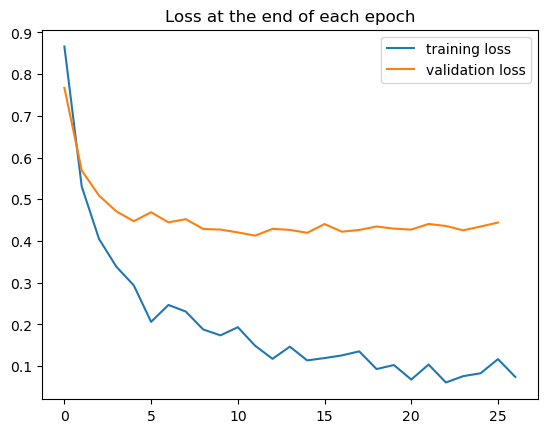

In [52]:
# Plot Losses
plt.plot([t.cpu().detach().numpy() for t in train_loss_ShuffleNet], label='training loss')
plt.plot([t.cpu().detach().numpy() for t in val_loss_ShuffleNet], label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

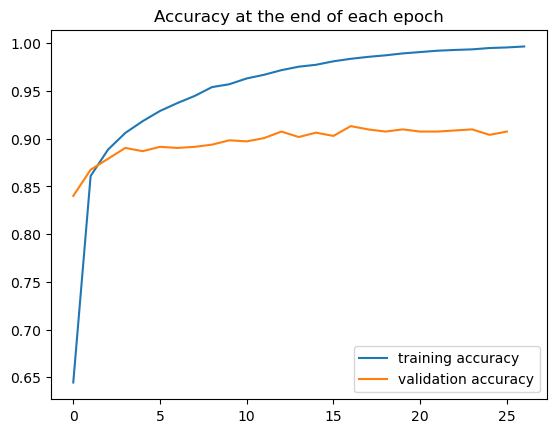

In [53]:
# Plot accuracy
plt.plot([t.cpu() / train_data_len for t in train_corr_ShuffleNet], label='training accuracy')
plt.plot([t.cpu() / val_data_len for t in val_corr_ShuffleNet], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [54]:
# How many accurate predictions were made per epoch
print("Train Correct:", train_corr_ShuffleNet)
print("\t")
print("Validation Correct:", val_corr_ShuffleNet)

Train Correct: [tensor(3195, device='cuda:0'), tensor(4267, device='cuda:0'), tensor(4404, device='cuda:0'), tensor(4491, device='cuda:0'), tensor(4552, device='cuda:0'), tensor(4605, device='cuda:0'), tensor(4646, device='cuda:0'), tensor(4683, device='cuda:0'), tensor(4729, device='cuda:0'), tensor(4744, device='cuda:0'), tensor(4774, device='cuda:0'), tensor(4793, device='cuda:0'), tensor(4817, device='cuda:0'), tensor(4835, device='cuda:0'), tensor(4845, device='cuda:0'), tensor(4863, device='cuda:0'), tensor(4876, device='cuda:0'), tensor(4886, device='cuda:0'), tensor(4894, device='cuda:0'), tensor(4904, device='cuda:0'), tensor(4911, device='cuda:0'), tensor(4918, device='cuda:0'), tensor(4922, device='cuda:0'), tensor(4925, device='cuda:0'), tensor(4932, device='cuda:0'), tensor(4935, device='cuda:0'), tensor(4940, device='cuda:0')]
	
Validation Correct: [tensor(735, device='cuda:0'), tensor(759, device='cuda:0'), tensor(769, device='cuda:0'), tensor(779, device='cuda:0'), tens

## Load saved model (ShuffleNet) 

In [33]:
ShuffleNet_best = models.shufflenet_v2_x2_0(pretrained=True)
ShuffleNet_best.fc = nn.Linear(2048, 11)
ShuffleNet_best.load_state_dict(torch.load('BestShuffleNet.pt'))

<All keys matched successfully>

In [34]:
ShuffleNet_best.to(device)
next(ShuffleNet_best.parameters()).is_cuda

True

## Test the model (ShuffleNet)

In [57]:
# Test the model
test_corr_ShuffleNet = []
test_model(ShuffleNet_best, criterion_ShuffleNet, test_loader_ShuffleNet, test_corr_ShuffleNet)

In [58]:
# Evaluate test data
print("Test Correct:", test_corr_ShuffleNet)
print("Test Accuracy:", accuracy_global, "%")

Test Correct: [tensor(923, device='cuda:0')]
Test Accuracy: 89.612 %


## Confusion Matrix Metrics (ShuffleNet)

**********************
Individual Class Metrics:
**********************
	
Class: 0
---------------------
True Positive (TP): 90
True Negative (TN): 927
False Positive (FP): 9
False Negative (FN): 4
Precision: 0.909
Recall: 0.957
F1 Score: 0.933
	
Class: 1
---------------------
True Positive (TP): 118
True Negative (TN): 890
False Positive (FP): 6
False Negative (FN): 16
Precision: 0.952
Recall: 0.881
F1 Score: 0.915
	
Class: 2
---------------------
True Positive (TP): 51
True Negative (TN): 950
False Positive (FP): 17
False Negative (FN): 12
Precision: 0.75
Recall: 0.81
F1 Score: 0.779
	
Class: 3
---------------------
True Positive (TP): 91
True Negative (TN): 898
False Positive (FP): 21
False Negative (FN): 20
Precision: 0.812
Recall: 0.82
F1 Score: 0.816
	
Class: 4
---------------------
True Positive (TP): 82
True Negative (TN): 942
False Positive (FP): 3
False Negative (FN): 3
Precision: 0.965
Recall: 0.965
F1 Score: 0.965
	
Class: 5
---------------------
True Positive (TP): 51
True

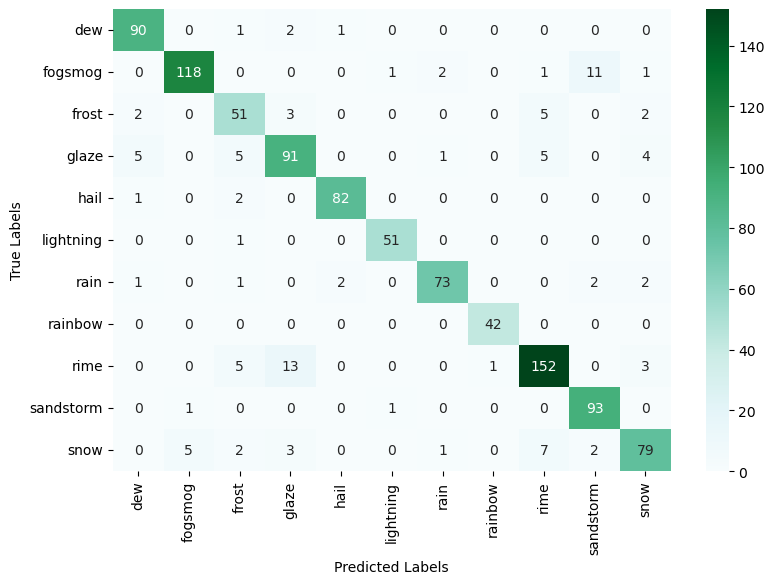

In [35]:
show_confusion_matrix(ShuffleNet_best)

## Open a custom image and use the models for prediction

Custom image size: torch.Size([3, 224, 224])
	
Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
	


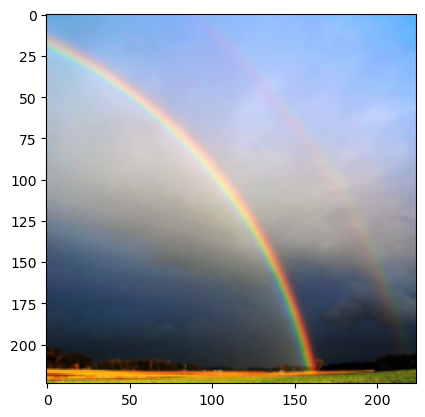

In [36]:
# Open a custom image
custom_img = Image.open('custom_images/1.jpg')

# Define transformations for the image
transform_custom = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

custom_img_t = transform_custom(custom_img)
print("Custom image size:", custom_img_t.shape)
print("\t")

# Inverse normalize the image
custom_img_n = inv_normalize(custom_img_t)
plt.imshow(np.transpose(custom_img_n.numpy(), (1, 2, 0)));

print("Classes:", classes)
print("\t")

In [37]:
# ShuffleNet Model Prediction:
custom_img_prediction(ShuffleNet_best, "ShuffleNet")

ShuffleNet model prediction: 7
